In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
# loading the data  
df = pd.read_csv('train.csv')

# choosing the predictors and encoding the categorials
df = df[['SalePrice', 'CentralAir', 'GrLivArea', 'Street']]
df['CentralAir'] = df['CentralAir'].replace({'Y': 1, 'N': 0})
df['Street'] = df['Street'].replace({'Pave': 1, 'Grvl': 0})

In [3]:
#deleting high leverage points
X = df[['GrLivArea']]  # Select the specific predictor variable
y = df['SalePrice']
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Calculate influence for the specific predictor
influence = model.get_influence()

# Calculate leverage for the specific predictor
leverage = influence.hat_matrix_diag

# Calculate mean leverage for the specific predictor
mean_leverage = np.mean(leverage)

# Define a threshold for high leverage points
leverage_threshold = 3 * mean_leverage

# Find indices of high leverage points for the specific predictor
high_leverage_indices = np.where(leverage > leverage_threshold)[0]

# Print or analyze the high leverage indices for the specific predictor
print("High Leverage Indices:", high_leverage_indices)

# Define a threshold for high leverage points (three times the mean leverage)
leverage_threshold = 3 * mean_leverage

# Find indices of high leverage points
high_leverage_indices = np.where(leverage > leverage_threshold)[0]

# Remove high leverage points from the DataFrame
df = df.drop(index=high_leverage_indices)

High Leverage Indices: [  58  112  118  185  190  197  231  304  322  324  349  496  523  527
  533  583  608  635  642  691  745  769  798  803  961 1024 1031 1046
 1142 1169 1173 1175 1182 1268 1298 1312 1328 1353 1386]


# Stepwise Regression

In [4]:
# checking the first most significant predictor
df_p_values = pd.DataFrame(columns=['Column', 'p_values'])

for column in df.columns[1:]:   
    model = ols(f'SalePrice ~ {column}', data = df).fit()
    df_p_values = pd.concat([df_p_values, pd.DataFrame({'Column': [column], 'p_values': [model.pvalues[1]]})], ignore_index=True)

print(df_p_values.loc[df_p_values['p_values'].idxmin()])   

Column      GrLivArea
p_values          0.0
Name: 1, dtype: object


GrLivArea made it into the model

In [5]:
# checking the second most significant predictor
df_p_values = pd.DataFrame(columns=['Column', 'p_values'])

for column in ['Street', 'CentralAir']:   
    model = ols(f'SalePrice ~ GrLivArea + {column} + GrLivArea*({column})', data = df).fit()
    df_p_values = pd.concat([df_p_values, pd.DataFrame({'Column': ['GrLivArea', column, f'GrLivArea*{column}'], 'p_values': [model.pvalues[1], model.pvalues[2], model.pvalues[3]]})], ignore_index=True)

print(df_p_values)

                 Column      p_values
0             GrLivArea  1.419950e-02
1                Street  5.449144e-01
2      GrLivArea*Street  6.471998e-01
3             GrLivArea  1.288950e-08
4            CentralAir  1.226075e-01
5  GrLivArea*CentralAir  4.578256e-10


CentralAir Interaction made it into the model.

In [6]:
# checking the third most significant predictor
model = ols('SalePrice ~ GrLivArea + CentralAir + GrLivArea*CentralAir + Street + Street*GrLivArea + Street*CentralAir' , data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     263.3
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.24e-226
Time:                        17:33:37   Log-Likelihood:                -17337.
No. Observations:                1421   AIC:                         3.469e+04
Df Residuals:                    1414   BIC:                         3.472e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.764e+04   6.32e+04      0.437      0.662   -9.63e+04    1.52e+05
GrLivArea               59.5249     57.195      1.041      0.298     -52.672     171.722
CentralAir           -2.556e+04   4.68e+04     -0.546      0.585   -1.17e+05    6.62e+04
GrLivArea:CentralAir    60.2172      9.653      6.238      0.000      41.281      79.153
Street                8809.9369    6.3e+04      0.140      0.889   -1.15e+05    1.32e+05
Street:GrLivArea        -7.6008     56.511     -0.134      0.893    -118.456     103.254
Street:CentralAir     3923.0962   4.64e+04      0.085      0.933   -8.71e+04    9.49e+04
==============================================================================
Omnibus:                      333.954   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.651
Skew:                           1.042   Prob(JB):                         0.00
Kurtosis:                       7.585   Cond. No.                     1.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Neither street, nor any of its interactions is significant, which is why we leave it out of the model.

### the semi-final model with interaction
Model A

In [7]:
model = ols('SalePrice ~ GrLivArea + CentralAir + GrLivArea*CentralAir' , data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     527.7
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.33e-230
Time:                        17:33:37   Log-Likelihood:                -17337.
No. Observations:                1421   AIC:                         3.468e+04
Df Residuals:                    1417   BIC:                         3.470e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.633e+04   1.31e+04      2.764      0.006    1.05e+04    6.21e+04
GrLivArea               51.9818      9.086      5.721      0.000      34.159      69.805
CentralAir           -2.158e+04    1.4e+04     -1.545      0.123    -4.9e+04    5823.319
GrLivArea:CentralAir    60.1919      9.589      6.277      0.000      41.381      79.003
==============================================================================
Omnibus:                      333.837   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1500.912
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       7.584   Cond. No.                     3.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The semi final regression formula

In [8]:
print("Regression Coefficients:")
print(f"{round(model.params[0], 2)} +{round(model.params[1], 2)}*SquareFeet {round(model.params[2], 2)}*AirCondition +{round(model.params[3], 2)}*AirCondition*SquareFeet")

Regression Coefficients:
36333.96 +51.98*SquareFeet -21583.96*AirCondition +60.19*AirCondition*SquareFeet


### Visulasize the Interaction

In [9]:
# creating two dataframes to predict.
df_0 = df.query('CentralAir == 0')
df_1 = df.query('CentralAir == 1')

# Creating the predictions for no aircondition
df_0['predicted'] = model.params[0] + model.params[1]*df_0.GrLivArea
# Creating the predictions for aircondition
df_1['predicted'] = model.params[0] + model.params[1]*df_1.GrLivArea + model.params[2] + model.params[3]*df_1.GrLivArea

C:\Users\Max_G\AppData\Local\Temp\ipykernel_6368\2839835842.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['predicted'] = model.params[0] + model.params[1]*df_0.GrLivArea
C:\Users\Max_G\AppData\Local\Temp\ipykernel_6368\2839835842.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['predicted'] = model.params[0] + model.params[1]*df_1.GrLivArea + model.params[2] + model.params[3]*df_1.GrLivArea


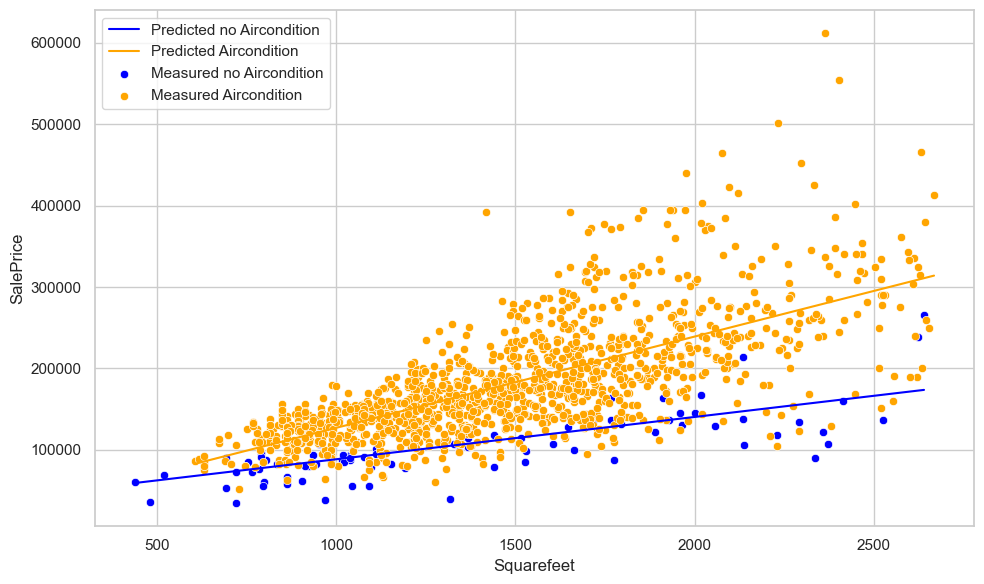

In [10]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Line plots for predicted values
sns.lineplot(x='GrLivArea', y='predicted', data=df_0, ax=ax, label='Predicted no Aircondition', color='blue')
sns.lineplot(x='GrLivArea', y='predicted', data=df_1, ax=ax, label='Predicted Aircondition', color='orange')

# Plot Scatter plots for SalePrice vs. GrLivArea
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_0, ax=ax, label='Measured no Aircondition', color='blue')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_1, ax=ax, label='Measured Aircondition', color='orange')

# Add title
ax.set_title('')
ax.set_xlabel('Squarefeet')
ax.set_ylabel('SalePrice')
ax.legend()

plt.tight_layout()
plt.show()


### Testing and transforming

While the interaction looks good, there might be some Heterodascity going on, plus there are outliers

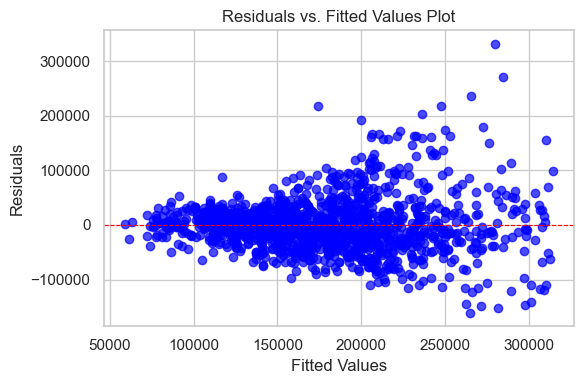

In [11]:
# Create a residuals vs fit plot
residuals = model.resid

plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linewidth=0.8, linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

Deleting Outliers

In [12]:
residuals = model.resid

# Identify outliers using Z-score
z_scores = np.abs((residuals - residuals.mean()) / residuals.std())
df['z_scores'] = z_scores   # Select observations with z-score > 2
df = df.query('z_scores <= 2') 

Running tests for heteroskedacity

In [13]:
model = ols('SalePrice ~ GrLivArea + CentralAir + GrLivArea*CentralAir' , data = df).fit()
residuals = model.resid

X = sm.add_constant(df['GrLivArea']) 
results = het_white(residuals, X)

# Print the test results
print('White Test Results:')
print(f'Lagrange Multiplier Statistic: {results[0]:.4f}')
print(f'Lagrange Multiplier p-value: {results[1]:.4f}')
print(f'F-statistic: {results[2]:.4f}')
print(f'F-statistic p-value: {results[3]:.4f}')

White Test Results:
Lagrange Multiplier Statistic: 117.8417
Lagrange Multiplier p-value: 0.0000
F-statistic: 64.4439
F-statistic p-value: 0.0000


In [14]:
_, p_value, _, _ = het_breuschpagan(residuals, X)

# Print the test results
print(f'Breusch-Pagan Test p-value: {p_value}')
if p_value < 0.05:
    print('Heteroscedasticity is present.')
else:
    print('No evidence of heteroscedasticity.')

Breusch-Pagan Test p-value: 7.996262021412446e-25
Heteroscedasticity is present.


Trying to remedy heteroskedacity

In [15]:
model = ols('np.log(SalePrice) ~ GrLivArea + CentralAir + GrLivArea*CentralAir' , data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     760.7
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.28e-288
Time:                        17:33:43   Log-Likelihood:                 173.56
No. Observations:                1343   AIC:                            -339.1
Df Residuals:                    1339   BIC:                            -318.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.8653      0.058    187.041      0.000      10.751      10.979
GrLivArea                0.0005   4.01e-05     11.832      0.000       0.000       0.001
CentralAir               0.2996      0.062      4.828      0.000       0.178       0.421
GrLivArea:CentralAir     0.0001   4.27e-05      2.599      0.009    2.72e-05       0.000
==============================================================================
Omnibus:                       60.722   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.303
Skew:                          -0.482   Prob(JB):                     1.99e-16
Kurtosis:                       3.601   Cond. No.                     2.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### checking if the regression assumptions are met

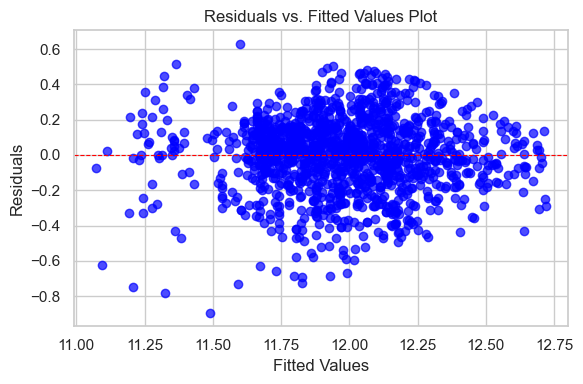

In [16]:
residuals = model.resid

plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linewidth=0.8, linestyle='--') 
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
X = sm.add_constant(df['GrLivArea']) 
results = het_white(residuals, X)

# Print the test results
print('White Test Results:')
print(f'Lagrange Multiplier Statistic: {results[0]:.4f}')
print(f'Lagrange Multiplier p-value: {results[1]:.4f}')
print(f'F-statistic: {results[2]:.4f}')
print(f'F-statistic p-value: {results[3]:.4f}')

White Test Results:
Lagrange Multiplier Statistic: 5.4699
Lagrange Multiplier p-value: 0.0649
F-statistic: 2.7400
F-statistic p-value: 0.0649


In [18]:
_, p_value, _, _ = het_breuschpagan(residuals, X)

# Print the test results
print(f'Breusch-Pagan Test p-value: {p_value}')
if p_value < 0.05:
    print('Heteroscedasticity is present.')
else:
    print('No evidence of heteroscedasticity.')

Breusch-Pagan Test p-value: 0.37109786000129175
No evidence of heteroscedasticity.


### Visualise the final model

In [19]:
df_0 = df.query('CentralAir == 0')
df_1 = df.query('CentralAir == 1')
# Creating the predictions for no aircondition with updated data set
df_0['predicted_transformed'] = model.params[0] + model.params[1]*df_0.GrLivArea
# Creating the predictions for aircondition
df_1['predicted_transformed'] = model.params[0] + model.params[1]*df_1.GrLivArea + model.params[2] + model.params[3]*df_1.GrLivArea
# creating the log SalePrice
df_0['log_SalePrice'] = np.log(df_0['SalePrice'])
df_1['log_SalePrice'] = np.log(df_1['SalePrice'])

C:\Users\Max_G\AppData\Local\Temp\ipykernel_6368\1461853094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['predicted_transformed'] = model.params[0] + model.params[1]*df_0.GrLivArea
C:\Users\Max_G\AppData\Local\Temp\ipykernel_6368\1461853094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['predicted_transformed'] = model.params[0] + model.params[1]*df_1.GrLivArea + model.params[2] + model.params[3]*df_1.GrLivArea
C:\Users\Max_G\AppData\Local\Temp\ipykernel_6368\1461853094.py:8: SettingWi

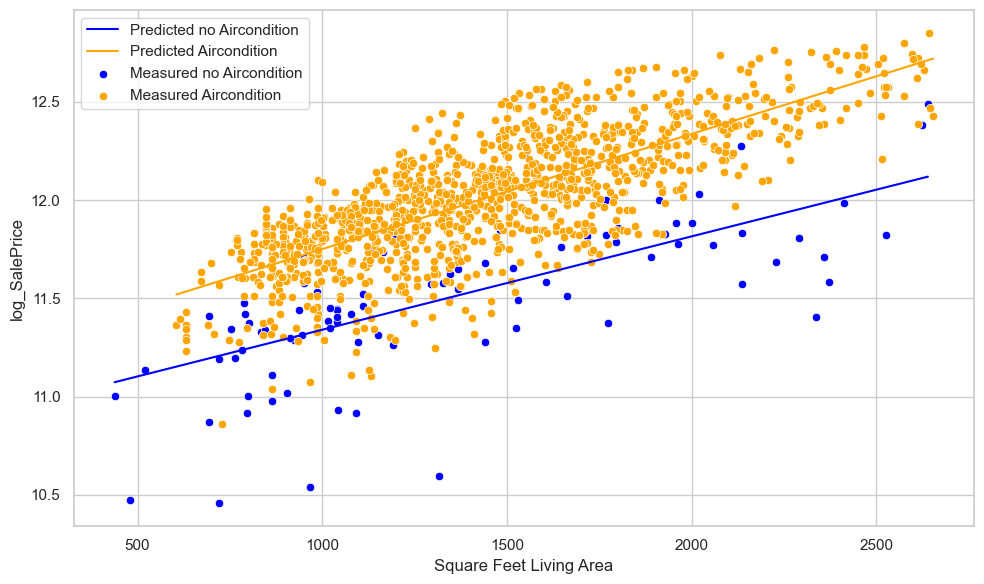

In [20]:
sns.set(style="whitegrid")

# Create a figure and a single axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Line plots for predicted values
sns.lineplot(x='GrLivArea', y='predicted_transformed', data=df_0, ax=ax, label='Predicted no Aircondition', color='blue')
sns.lineplot(x='GrLivArea', y='predicted_transformed', data=df_1, ax=ax, label='Predicted Aircondition', color='orange')

# Plot Scatter plots for SalePrice vs. GrLivArea
sns.scatterplot(x='GrLivArea', y='log_SalePrice', data=df_0, ax=ax, label='Measured no Aircondition', color='blue')
sns.scatterplot(x='GrLivArea', y='log_SalePrice', data=df_1, ax=ax, label='Measured Aircondition', color='orange')

# Customize the plot
ax.set_title('')
ax.set_xlabel('Square Feet Living Area')
ax.set_ylabel('log_SalePrice')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

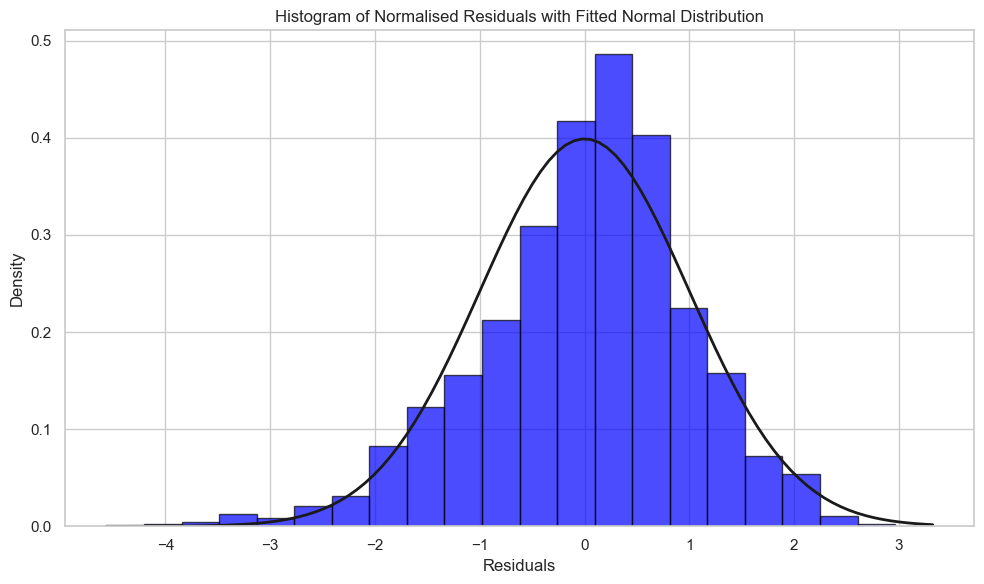

In [21]:
# Plot the histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals/residuals.std(), bins=20, density=True, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Normalised Residuals with Fitted Normal Distribution')
plt.grid(True)

# Plot the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)

plt.tight_layout()
plt.show()

### Interpretationg the increase with the non log sale price

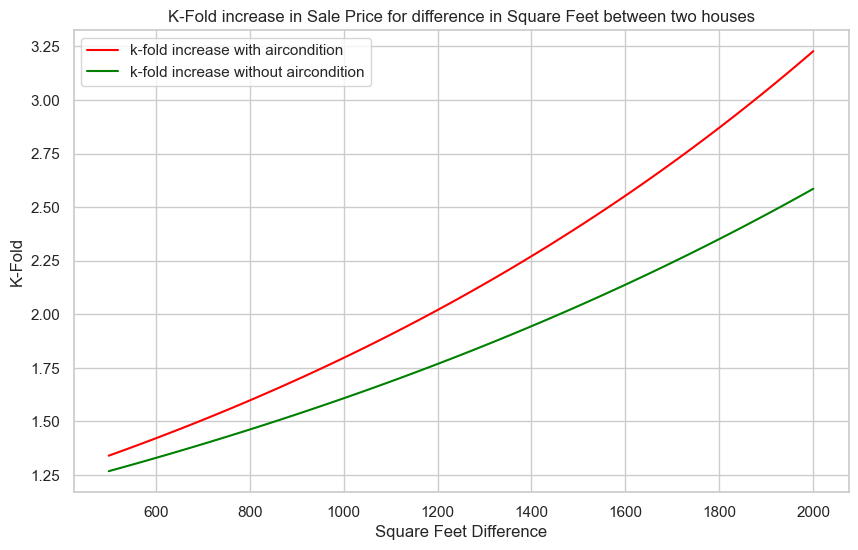

In [22]:
x_range = np.linspace(500, 2000, num=100)

# Calculate the predicted exponential values using the model
change_aircon = np.exp(x_range * (model.params[1] + model.params[3]))
change_no_aircon = np.exp(x_range * model.params[1])

# Plot the exponential relationship
plt.figure(figsize=(10, 6))
plt.plot(x_range, change_aircon, color='red', label='k-fold increase with aircondition')
plt.plot(x_range, change_no_aircon, color='green', label='k-fold increase without aircondition')
plt.xlabel('Square Feet Difference')
plt.ylabel('K-Fold')
plt.title('K-Fold increase in Sale Price for difference in Square Feet between two houses')
plt.legend()
plt.grid(True)
plt.show()


### Plotting and saving the regression summary

In [23]:
regression_results = model.summary()
with open('regression_table.txt', 'w') as f:
    f.write(regression_results.as_text())

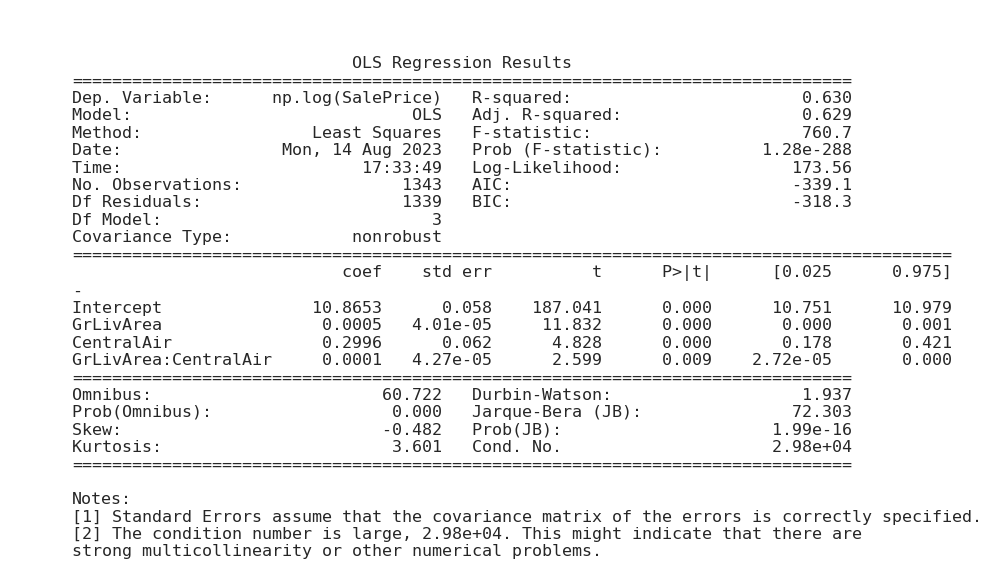

In [24]:
from tabulate import tabulate

# Get regression results as a string
regression_results = model.summary().as_text()

# Split the string into rows and columns
rows = regression_results.split('\n')

# Format the table using tabulate
table_str = '\n'.join(rows)
table_str = table_str.replace('---', '')

# Export the formatted table as an image
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.1, 0.9, table_str, va='top', transform=ax.transAxes, fontfamily='monospace')
ax.axis('off')

plt.savefig('regression_table.png', bbox_inches='tight')